In [79]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
import urllib.request

In [80]:
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']

In [81]:
def create_coco(annotation_directory, data_name, categories):
    annFile='{}/instances_{}.json'.format(annotation_directory,data_name)
    coco=COCO(annFile)
    image_ids = []
    
    category_ids = coco.getCatIds(catNms=categories)
    for category in category_ids:
        temp_img_ids = imgIds = coco.getImgIds(catIds=category)
        image_ids += temp_img_ids
    
    print(f"Found {len(image_ids)} images for {categories}")
    
    return category_ids, image_ids, coco
        

In [82]:
def download_coco_images(coco, imgIds, save_dir, verbose=False):
    current_image_count = 1
    total_image_count = len(imgIds)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for img_id in imgIds:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        url = img_info.get('coco_url')
        
        img_count_string = f'{current_image_count}/{total_image_count}'

        if url is None:
            print(f"No URL found for image {file_name}, skipping.")
            continue

        save_path = os.path.join(save_dir, file_name)
        if not os.path.exists(save_path):
            try:
                urllib.request.urlretrieve(url, save_path)
                if verbose: print(f"{img_count_string} Downloaded {file_name}")
            except Exception as e:
                if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
        else:
            if verbose: print(f"{img_count_string} Image already exists: {file_name}")
        
        current_image_count += 1
    
    print(f'Interfaced with {current_image_count-1} images')

In [83]:
def display_image(img):
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()

def display_bounded_image(coco, img, category_ids):
    I = io.imread(img['coco_url'])
    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=category_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)

In [84]:
val_category_ids, val_image_ids, val_coco = create_coco(annotation_dir, val_data_name, relevant_categories)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Found 701 images for ['cat', 'dog', 'cow', 'horse', 'bird']


In [85]:
# Only use when ready to train full model
# train_category_ids, train_image_ids, train_coco = create_coco(annotation_dir, train_data_name, relevant_categories)

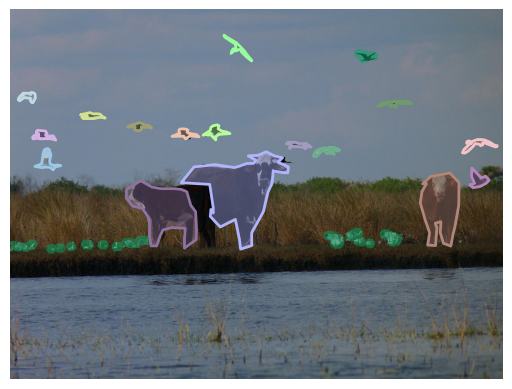

In [86]:
img = val_coco.loadImgs(val_image_ids[np.random.randint(0,len(val_image_ids))])[0]
display_bounded_image(val_coco, img, val_category_ids)

In [87]:
download_coco_images(val_coco, val_image_ids, val_image_dir)

Interfaced with 701 images
